In [16]:
%matplotlib notebook
%reload_ext autoreload
%autoreload 2

import sys
import os
import matplotlib.pyplot as plt

sys.path.append('../')
sys.path.append('../paretoviz')
from paretoviz import plotting as pplt
from paretoviz import decorator as dcor
from paretoviz.utils import fmt
from paretoviz.utils import vectorops as vops

# Do all these plots with centroid based coloring

# rawfpath = "../data/spherical/spherical-3d.out"
# rawfpath = "../data/spherical/spherical-4d.out"
# rawfpath = "../data/spherical/spherical-8d.out"

# rawfpath = "../data/knee/knee-3d.out"
# rawfpath = "../data/knee/knee-4d.out"
# rawfpath = "../data/knee/knee-8d.out"

# rawfpath = "../data/line-surface/line-3d.out"
# rawfpath = "../data/line-surface/line-4d.out"
# rawfpath = "../data/line-surface/line-6d.out"
# rawfpath = "../data/line-surface/line-8d.out"

# rawfpath = "../data/carcrash/carcrash-3d.out"
# rawfpath = "../data/carcrash/carcrash-c1/carcrash-c1-3d.out"
# rawfpath = "../data/carcrash/carcrash-c2/carcrash-c2-3d.out"

# Do all these plots with constraint based coloring

# rawfpath = "../data/knee-const/knee-const-3d.out"
# rawfpath = "../data/knee-const/knee-const-4d.out"
# rawfpath = "../data/knee-const/knee-const-8d.out"

# rawfpath = "../data/knee-const-mod/knee-const-mod-3d.out"
# rawfpath = "../data/knee-const-mod/knee-const-mod-4d.out"

# rawfpath = "../data/isolated/isolated-3d.out"
# rawfpath = "../data/isolated/isolated-4d.out"
# rawfpath = "../data/isolated/isolated-8d.out"

# rawfpath = "../data/c2dtlz2/c2dtlz2-3d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-4d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-5d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-8d.out"

# rawfpath = "../data/c2dtlz2/c2dtlz2-c1/c2dtlz2-c1-3d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-c2/c2dtlz2-c2-3d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-c3/c2dtlz2-c3-3d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-c4/c2dtlz2-c4-3d.out"

# rawfpath = "../data/gaa-das/gaa-das-10d.out"
rawfpath = "../data/gaa-lhs/gaa-lhs-10d.out"

# some ML data sets
# rawfpath = "../data/airofoil/airofoil-5d.out"
# rawfpath = "../data/banknote/banknote-4d.out"
# rawfpath = "../data/blood/blood-4d.out"
# rawfpath = "../data/cccp/cccp-4d.out"
# rawfpath = "../data/concrete/concrete-8d.out"
# rawfpath = "../data/iris/iris-4d.out"
# rawfpath = "../data/mammogram/mammogram-5d.out"
# rawfpath = "../data/wil/wil-7d.out"
# rawfpath = "../data/yeast/yeast-8d.out"

# do visualization based on distance from the centroid?
docentroid = False

# get the path and filename from the rawfpath
path, rawfile = os.path.split(rawfpath)
rawpoints = fmt.load(rawfpath)

# get the prefix
prefix = rawfile.split('.')[0]

# load the normalized points
points = fmt.load(os.path.join(path, prefix + "-norm.out"))

# load the CV values
cvfpath = os.path.join(path, prefix + "-cv.out")
if not docentroid and os.path.exists(cvfpath):
    cv = [v[0] if len(v) == 1 else v for v in fmt.load(cvfpath)]
    [low, up] = vops.get_bound(cv)
    cv = vops.normalize(cv, low, up)
    color = dcor.recolor_by_cv(cv)
else:
    color = dcor.recolor_by_centroid(points)

# load the normalized trade-off values
mufpath = os.path.join(path, prefix + "-norm-mu.out")
knee_idx = None
if os.path.exists(mufpath):
    mu = [v[0] if len(v) == 1 else v for v in fmt.load(mufpath)]
    # resize the points w.r.t. trade-offs
    size = dcor.rescale_by_tradeoff(mu)
    (color, knee_idx) = dcor.recolor_by_tradeoff(size, color)

# load the class labels
classfpath = os.path.join(path, prefix + "-class.out")
if os.path.exists(classfpath):
    labels = [v[0] if len(v) == 1 else v for v in \
            fmt.load(classfpath, dtype = dcor.dtypes[prefix])]
    color = dcor.recolor_by_labels(labels, dtype = dcor.dtypes[prefix])
    size = [5.0 for _ in range(len(points))]

# alpha values
alpha = [0.2, 0.8] # alpha for plots with knee
# alpha = [1.0, 1.0] # alpha for general case

def pcp(X, title = "", show_legend = False, color = None, label = "f{:d}"):
    df = pd.DataFrame(X, columns = [label.format(i+1) for i in range(X.shape[1])])
    df['X'] = ['X_%s' % i for i in range(X.shape[0])]
    if color is None:
        ax = pd.plotting.parallel_coordinates(df, 'X')
        ax.grid(False)
    else:
        ax = pd.plotting.parallel_coordinates(df, 'X', color = color)
        ax.grid(False)
    if not show_legend:
        plt.gca().legend_.remove()
    plt.title(title)

<IPython.core.display.Javascript object>


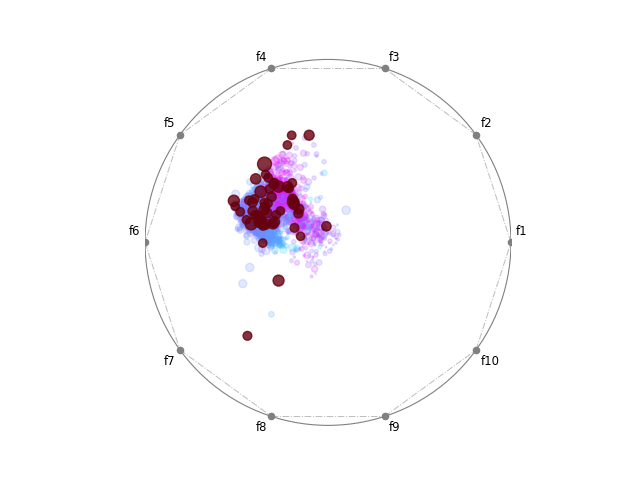

In [17]:
# Do the radviz plot
(fig, ax) = pplt.radviz(points, s = size, c = color, alpha = alpha, knee_idx = knee_idx)

# save the scatter plot
radvizfpath = os.path.join(path, prefix + "-radviz.pdf")
plt.savefig(radvizfpath, transparent = False)

plt.show()

len(knee_pts): 53
len(boundary_pts): 1481


<IPython.core.display.Javascript object>


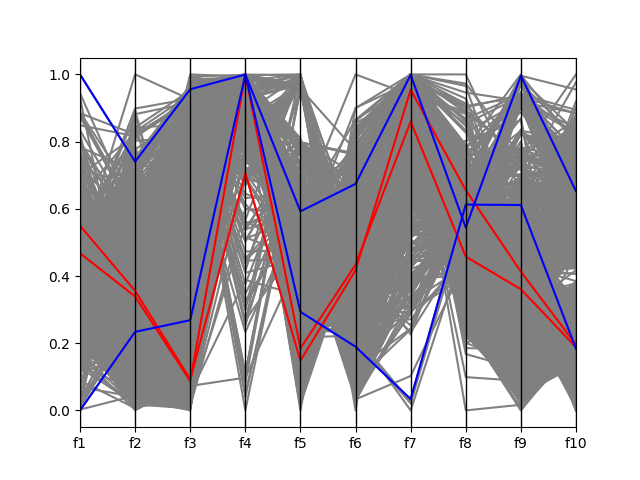

In [18]:
# Do a pcp plot

import numpy as np
import pandas as pd

layers = fmt.load(os.path.join(path, prefix + "-norm-layers.out"), dtype = 'int')

all_idx = range(len(points))
non_knee_idx = list(set(all_idx) - set(knee_idx))

knee_pts = [points[i] for i in knee_idx]
non_knee_pts = [points[i] for i in non_knee_idx]
boundary_pts = [points[i] for i in layers[0]]

knee_pts.sort()
boundary_pts.sort()

print("len(knee_pts):", len(knee_pts))
print("len(boundary_pts):", len(boundary_pts))

points.extend([knee_pts[-1], knee_pts[-3]])
points.extend([boundary_pts[0], boundary_pts[-1]])

color = ['gray' for c in range(len(color))]
color.extend(['red', 'red'])
# color.extend(['green', 'blue', 'black'])
color.extend(['blue', 'blue', 'blue'])

F = np.array(points)
plt.figure()
pcp(F, "", color = color)

outfile = os.path.join(path, prefix + "-pcp.pdf")
plt.savefig(outfile, transparent = False, bbox_inches = 'tight', pad_inches = 0)

plt.show()

<IPython.core.display.Javascript object>


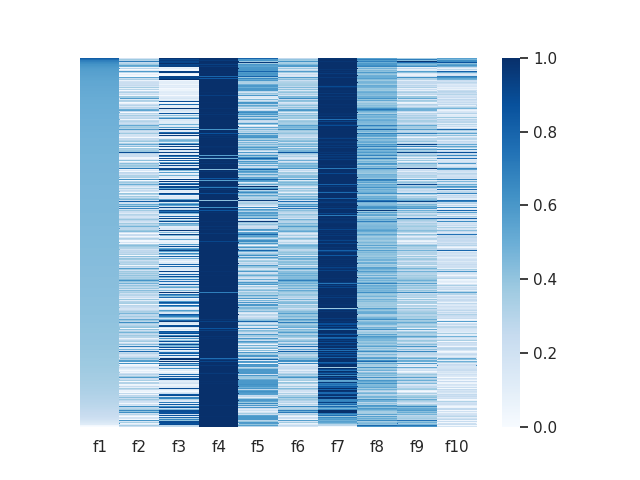

In [19]:
# Do a heatmap plot

import seaborn as sns

xtickl = ["f{0:d}".format(i+1) for i in range(len(points[0]))]

sns.set()
points_ = sorted(points, reverse = True)
data = np.array(points_)

plt.figure()
ax = sns.heatmap(data, yticklabels = False, xticklabels = xtickl, cmap = 'Blues')

outfile = os.path.join(path, prefix + "-heatmap.pdf")
plt.savefig(outfile, transparent = False, bbox_inches = 'tight', pad_inches = 0)

plt.show()